In [11]:
%matplotlib notebook
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
# from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *
    
def FRED_plateau(time, t_0, tau_D, tau_R, t_plateau, A, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    t_peak = np.sqrt(tau_D*tau_R)
    
#     t[t<=0] = 1e-2
#     t[(t-t_plateau) == 0] = t_plateau + 1e-2
    
    rise_mask = ((t <= t_peak) * (t > 0))
    plateau_mask = ((t > t_peak) * (t <= (t_peak + t_plateau)))
    decay_mask = ((t > (t_peak + t_plateau)))
    
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.exp(-((tau_R/t[rise_mask]) + (t[rise_mask]/tau_D)))
    model[plateau_mask] = np.exp(-2.0*np.sqrt(tau_R/tau_D))
    model[decay_mask] = np.exp(-((tau_R/(t[decay_mask]-t_plateau)) + ((t[decay_mask]-t_plateau)/tau_D)))
        
    return (A * model) + C

def FRED(time, t_0, tau_D, tau_R, A, C):
    # Fast Rise Exponential Decay with plateau from Barriere et al. 2015
    t = time-t_0
    
    rise_mask = (t > 0)
    model = np.zeros(np.shape(t))
    
    model[rise_mask] = np.exp(-((tau_R/t[rise_mask]) + (t[rise_mask]/tau_D)))        
    return (A * model) + C

# Analyze burst shape

In [3]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/GRS_1741d9m2853/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/GRS_1741d9m2853/'

timing_dir = root_dir + 'timing_products/'
products_dir = root_dir + 'products/'
plot_dir = root_dir + 'figures/'


Working on Macbook


<IPython.core.display.Javascript object>


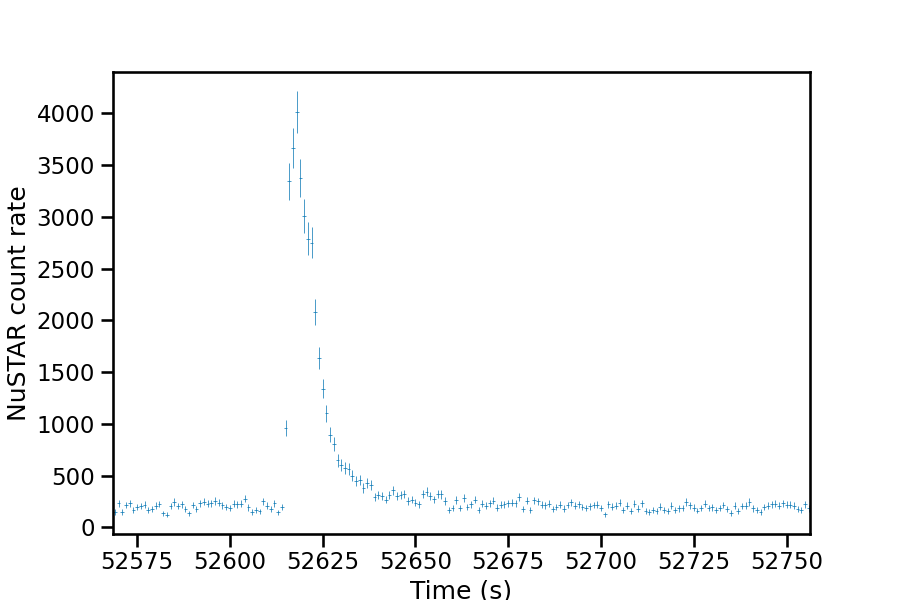

Text(0, 0.5, 'NuSTAR count rate')

In [8]:
plt.ion()
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
PI_max = 960   # 40.0 keV
# PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu90601317002A01_cl_bc.evt', \
            timing_dir + 'nu90601317002B01_cl_bc.evt')
events[0].set_xy_weights(centroid=[535.45075,442.58818])
events[1].set_xy_weights(centroid=[529.34253,440.82937])
# joined_events = events[0].join(events[1])
# print(events[0].time)

# hk_files = [fits.open(timing_dir + 'nu90601307002A_fpm_bc.hk'), fits.open(timing_dir + 'nu90601307002B_fpm_bc.hk')]
# hk_data_A = hk_files[0][1].data
curveA = nuproducts_to_stingray_lc(products_dir + 'nu90601317002A01_sr.lc')
curveB = nuproducts_to_stingray_lc(products_dir + 'nu90601317002B01_sr.lc')
curve_10s = curveA.rebin(dt_new=10)

t_start = np.min(curveA.time)

plt.figure(figsize = (9,6))
plt.errorbar(curveA.time-t_start, curveA.countrate+curveB.countrate, xerr=curveA.dt/2., yerr=np.sqrt(np.square(curveA.countrate_err) + np.square(curveB.countrate_err)), fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
# plt.close()


/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: underflow encountered in exp


<IPython.core.display.Javascript object>


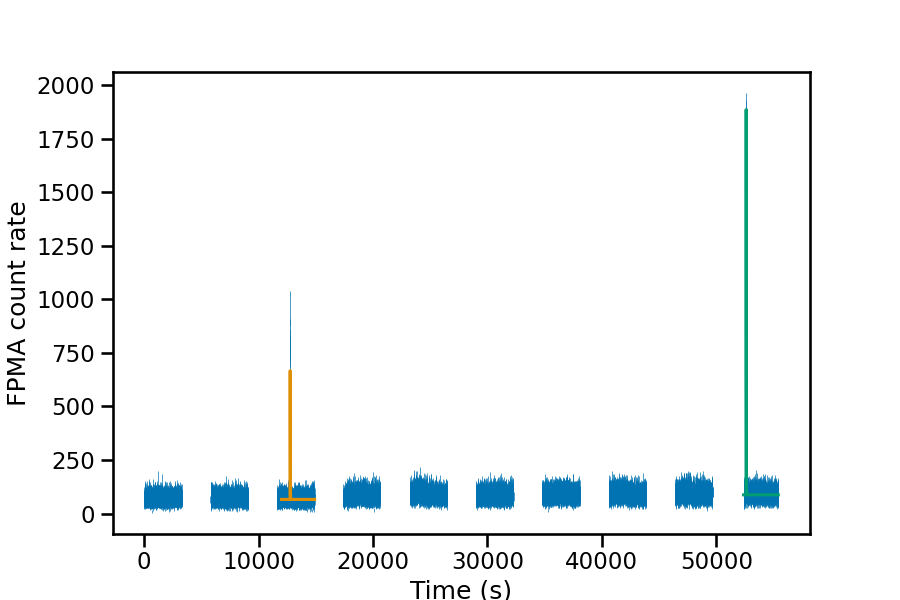

<IPython.core.display.Javascript object>


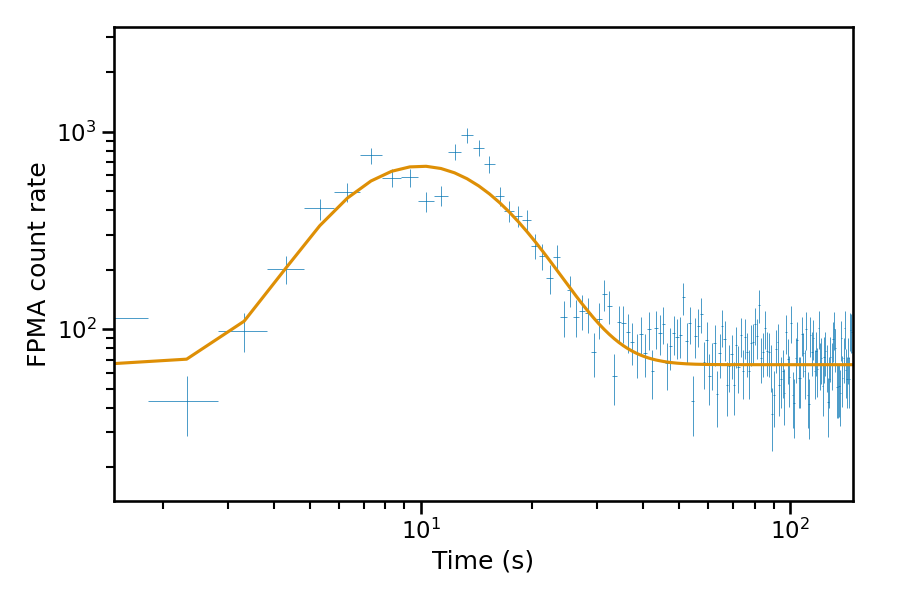

<IPython.core.display.Javascript object>


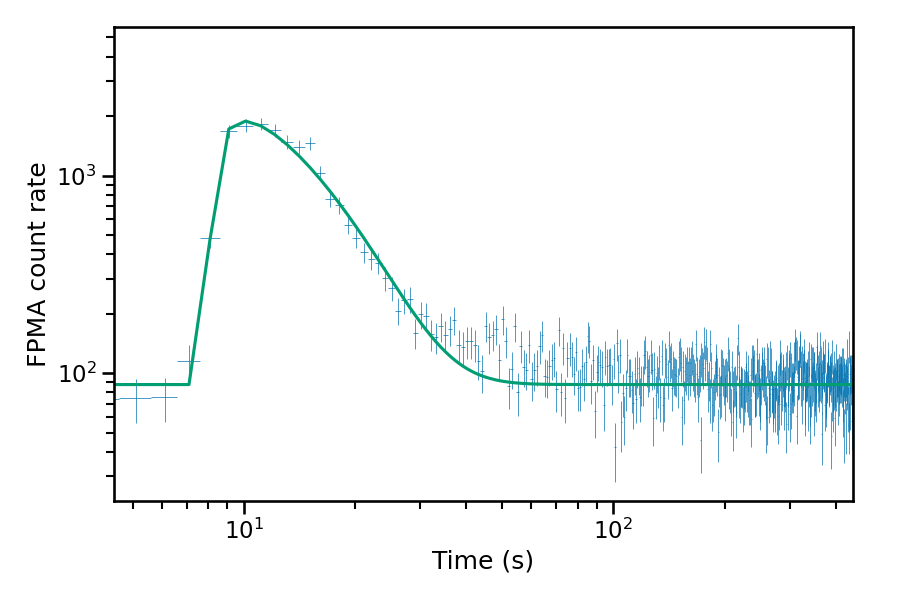

In [10]:
burst1_mask = ((curveA.time-t_start) > 12000) * ((curveA.time-t_start) < 15000)
burst2_mask = ((curveA.time-t_start) > 52000) * ((curveA.time-t_start) < 56000)
curveA.countrate_err[curveA.countrate==0.0] = 1.0

popt1, pcov1 = scipy.optimize.curve_fit(FRED, (curveA.time-t_start)[burst1_mask], curveA.countrate[burst1_mask], \
                                      p0 = [12750., 15., 0.5, 400., 100.], sigma = curveA.countrate_err[burst1_mask], \
                                       bounds = np.array([[12000., 15000], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

popt2, pcov2 = scipy.optimize.curve_fit(FRED, (curveA.time-t_start)[burst2_mask], curveA.countrate[burst2_mask], \
                                      p0 = [52600., 15., 0.5, 400., 12.], sigma = curveA.countrate_err[burst2_mask], \
                                       bounds = np.array([[52000., 56000], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

# popt1, pcov1 = scipy.optimize.curve_fit(FRED_plateau, (curveA.time-t_start)[burst1_mask], curveA.countrate[burst1_mask], \
#                                       p0 = [24150., 10., 15., 0.5, 400., 100.], sigma = curveA.countrate_err[burst1_mask], \
#                                        bounds = np.array([[24000., 24250], [3., np.inf], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

# popt2, pcov2 = scipy.optimize.curve_fit(FRED_plateau, (curveA.time-t_start)[burst2_mask], curveA.countrate[burst2_mask], \
#                                       p0 = [37880., 10., 15., 0.5, 400., 12.], sigma = curveA.countrate_err[burst2_mask], \
#                                        bounds = np.array([[37800., 38000], [3., np.inf], [0., np.inf], [0., np.inf], [0.0, np.inf], [0., np.inf]]).T)

# print(popt1)
# print(popt2)

plt.figure(figsize = (9,6))
plt.errorbar(curveA.time-t_start, curveA.countrate, xerr=curveA.dt/2., yerr=curveA.countrate_err, fmt='none', lw = 0.5)
plt.plot((curveA.time-t_start)[burst1_mask], FRED((curveA.time-t_start)[burst1_mask], *popt1))
plt.plot((curveA.time-t_start)[burst2_mask], FRED((curveA.time-t_start)[burst2_mask], *popt2))
plt.xlabel('Time (s)')
plt.ylabel('FPMA count rate')
# plt.close()


tmp_start = (popt1[0] + np.sqrt(popt1[1]*popt1[2])) - 10.
tmp_mask = ((curveA.time-t_start) > tmp_start) * ((curveA.time-t_start) < ((popt1[0]) + (100.*popt1[1])))
plt.figure(figsize = (9,6))
plt.errorbar((curveA.time-t_start)[tmp_mask] - tmp_start, curveA.countrate[tmp_mask], xerr=curveA.dt/2., yerr=curveA.countrate_err[tmp_mask], fmt='none', lw = 0.5)
plt.plot((curveA.time-t_start)[tmp_mask] - tmp_start, FRED((curveA.time-t_start)[tmp_mask], *popt1), color='C1')
plt.yscale('log')
plt.ylim((2.0,500.))
plt.xlim(10.,1000.)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('FPMA count rate')
plt.tight_layout()
plt.savefig(plot_dir + 'burst1_decay.pdf')
# plt.close()


tmp_start = (popt2[0] + np.sqrt(popt2[1]*popt2[2])) - 10.
tmp_mask = ((curveA.time-t_start) > tmp_start) * ((curveA.time-t_start) < ((popt2[0]) + (100.*popt2[1])))
plt.figure(figsize = (9,6))
plt.errorbar((curveA.time-t_start)[tmp_mask] - tmp_start, curveA.countrate[tmp_mask], xerr=curveA.dt/2., yerr=curveA.countrate_err[tmp_mask], fmt='none', lw = 0.5)
plt.plot((curveA.time-t_start)[tmp_mask] - tmp_start, FRED((curveA.time-t_start)[tmp_mask], *popt2), color='C2')
plt.yscale('log')
plt.ylim((2.0,500.))
plt.xlim(10.,1000.)
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('FPMA count rate')
plt.tight_layout()
plt.savefig(plot_dir + 'burst2_decay.pdf')
# plt.close()


burst1_decay_gti = [popt1[0] + np.sqrt(popt1[1]*popt1[2]) + t_start, popt1[0] + t_start + (50.*popt1[1])]
burst2_decay_gti = [popt2[0] + np.sqrt(popt2[1]*popt2[2]) + t_start, popt2[0] + t_start + (50.*popt2[1])]
